# In this notebook, we will demonstrate the emulation of evolutionary tracks from CNF<sub>giant</sub> and the determination of multi-dimensional posteriors through the flow's application to _Kepler_ red giants.

In [7]:
import os, sys
import numpy as np
import scipy as sp
import scipy.stats
import corner
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch, zuko
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import torch.utils.data as utils
import random
from tqdm import tqdm_notebook as tqdm
from matplotlib import colors as clr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from copy import copy
from matplotlib.lines import Line2D

print(torch.__version__, zuko.__version__)

assert zuko.__version__ == '0.3.2'

2.0.1+cu117 0.3.2


# Loading pre-trained flow

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

loadpath = os.path.split(os.getcwd())[0] + '/modelflows/pretrained_flows/cnf_giant.checkpoint'
checkpoint = torch.load(loadpath, map_location={'cuda:5': device})

flow = zuko.flows.NSF(features=8,  context=7, transforms=10, hidden_features=[256] * 10).to(device)
flow.load_state_dict(checkpoint['model_state_dict'])

print("=> loaded checkpoint (epoch {} - loss {})" .format(checkpoint['epoch'], checkpoint['loss']))

=> loaded checkpoint (epoch 1625 - loss -50.615817463629135)


# Loading in the training grid, selecting giants, and creating scaler functions for observables

In [9]:
data = pd.read_parquet(os.path.split(os.getcwd())[0] + '/grid/p-mode.parquet')

giant_cond =  (data.nu_max.values <= 300) & (data.eps > 0) &\
(data.dnu01 > -4.5) & (data.dnu01 < 15) & \
(data.dnu02 > 0) 

teff_scaler = StandardScaler()
d01_scaler = MinMaxScaler()
mms_shell_scaler = MinMaxScaler()
mms_core_scaler = MinMaxScaler()

In [10]:
Zsun, Xsun = 0.0134, 0.7381 # a09

# Full-grid emulation

## Here, we want to use input parameters $\mathbf{x}$ across the entire grid to condition the normalizing flow. We then sample from the flow, we should give us the distribution of observables from the grid.

### $\mathbf{x} = [M, \log_{10}Z, Y, \alpha, f_{\mathrm{ov, env}}, f_{\mathrm{ov, core}}, \nu_{\mathrm{max}}]$
### $\mathbf{y} = [T_{\mathrm{eff}}, \Delta\nu, \delta\nu_{01},  \delta\nu_{02},  \delta\nu_{03}, \epsilon, R, \tau]$



## First, we apply transformations to each vector following how they were transformed during training of the flow.

In [11]:
x_mass = data.star_mass.values[giant_cond]
x_feh = np.log10(data.Zinit.values[giant_cond])
x_init_helium = data.Yinit.values[giant_cond]
x_alpha = data.amlt.values[giant_cond]
x_ov_shell = mms_shell_scaler.fit_transform(data.fov_shell.values[giant_cond].reshape(-1,1)).squeeze()
x_ov_core = mms_core_scaler.fit_transform(data.fov_core.values[giant_cond].reshape(-1,1)).squeeze()
y_numax_scaled = np.log10(data.nu_max.values[giant_cond])

X = torch.Tensor(np.vstack([  x_mass, x_feh , x_init_helium, 
                            x_alpha, x_ov_shell, x_ov_core,
                           y_numax_scaled]).T).to(device)

# 6D vector X is mass, Z, Y, alpha, f_ov_env, f_ov_env, f_ov_core, and numax

y_teff = data.log_Teff.values[giant_cond]
y_teff_scaled = teff_scaler.fit_transform(y_teff.reshape(-1,1)).squeeze()
y_dnu_scaled = np.log10(data.Dnu_freq.values[giant_cond])
y_d01 = data.dnu01.values[giant_cond]
y_d01_scaled = d01_scaler.fit_transform(y_d01.reshape(-1,1)).squeeze()
y_d02 = data.dnu02.values[giant_cond]
y_d02_scaled = np.log10(y_d02)
y_d03 = data.dnu03.values[giant_cond]
y_d03_scaled = np.log10(y_d03 + 3)
y_eps = data.eps.values[giant_cond]
y_radius_scaled = np.log10(data.radius.values[giant_cond])
y_age = (data.star_age.values[giant_cond])/1e9
y_age_scaled = np.log10((y_age))

Y = torch.Tensor(np.vstack([ y_teff_scaled,
                            y_dnu_scaled, 
                            y_d01_scaled, 
                            y_d02_scaled, 
                            y_d03_scaled, 
                            y_eps, 
                            y_radius_scaled, y_age_scaled]).T).to(device)

# 8D vector is Teff, DeltaNu, d01, d02, d03, epsilon, radius, and age.

train_dataset = utils.TensorDataset(X, Y) # Define a Pytorch Tensor Dataset
train_dataloader = utils.DataLoader(train_dataset, batch_size=1024)

In [12]:
min(x_ov_shell), max(x_ov_shell)

(0.0, 0.9999999999999999)

# Here, we sample across the entire distribution.

## In the following, we pass the $\mathbf{x}$ of the whole training grid through the flow.

In [8]:
y_samps = []
y_logprobs = []
y_s = []
x_s = []

for (X_inp, Y_inp) in tqdm(train_dataloader, total=len(train_dataloader)):
    samps,logprobs = flow(X_inp).rsample_and_log_prob() # Sample from the Flow and calculate the point's log-probability
    y_logprobs.append(logprobs.data.cpu().numpy())
    
    y_s.append(Y_inp.data.cpu().numpy())
    x_s.append(X_inp.data.cpu().numpy())
    y_samps.append(samps.data.cpu().numpy())
    
y_s = np.concatenate(y_s)
y_samps = np.concatenate(y_samps)
y_logprobs = np.concatenate(y_logprobs)

<ipython-input-8-c07b050b7d59>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for (X_inp, Y_inp) in tqdm(train_dataloader, total=len(train_dataloader)):


  0%|          | 0/722 [00:00<?, ?it/s]

## Reversing transformations to each component in $\mathbf{x}$ and $\mathbf{y}$

In [9]:
cond = y_logprobs > np.percentile(y_logprobs, 5)

_pred = copy(y_samps[cond])
_output = copy(y_s)

transform_indices = [1, 3, 4, 6]
for idx in transform_indices:
    if idx == 4:
        _output[:, idx] = 10**_output[:, idx] - 3
        _pred[:, idx] = 10**_pred[:, idx] - 3
    else:
        _pred[:, idx] = 10**_pred[:, idx]
        _output[:, idx] = 10**_output[:, idx]
        
_pred[:, 2] = d01_scaler.inverse_transform(_pred[:, 2].reshape(-1, 1)).squeeze()
_output[:, 2] = d01_scaler.inverse_transform(_output[:, 2].reshape(-1, 1)).squeeze()

_pred[:, 0] = teff_scaler.inverse_transform(_pred[:, 0].reshape(-1,1)).squeeze()
_output[:, 0] = teff_scaler.inverse_transform(_output[:, 0].reshape(-1,1)).squeeze()


## This yields the giant part of Figure 2(a) from the paper!

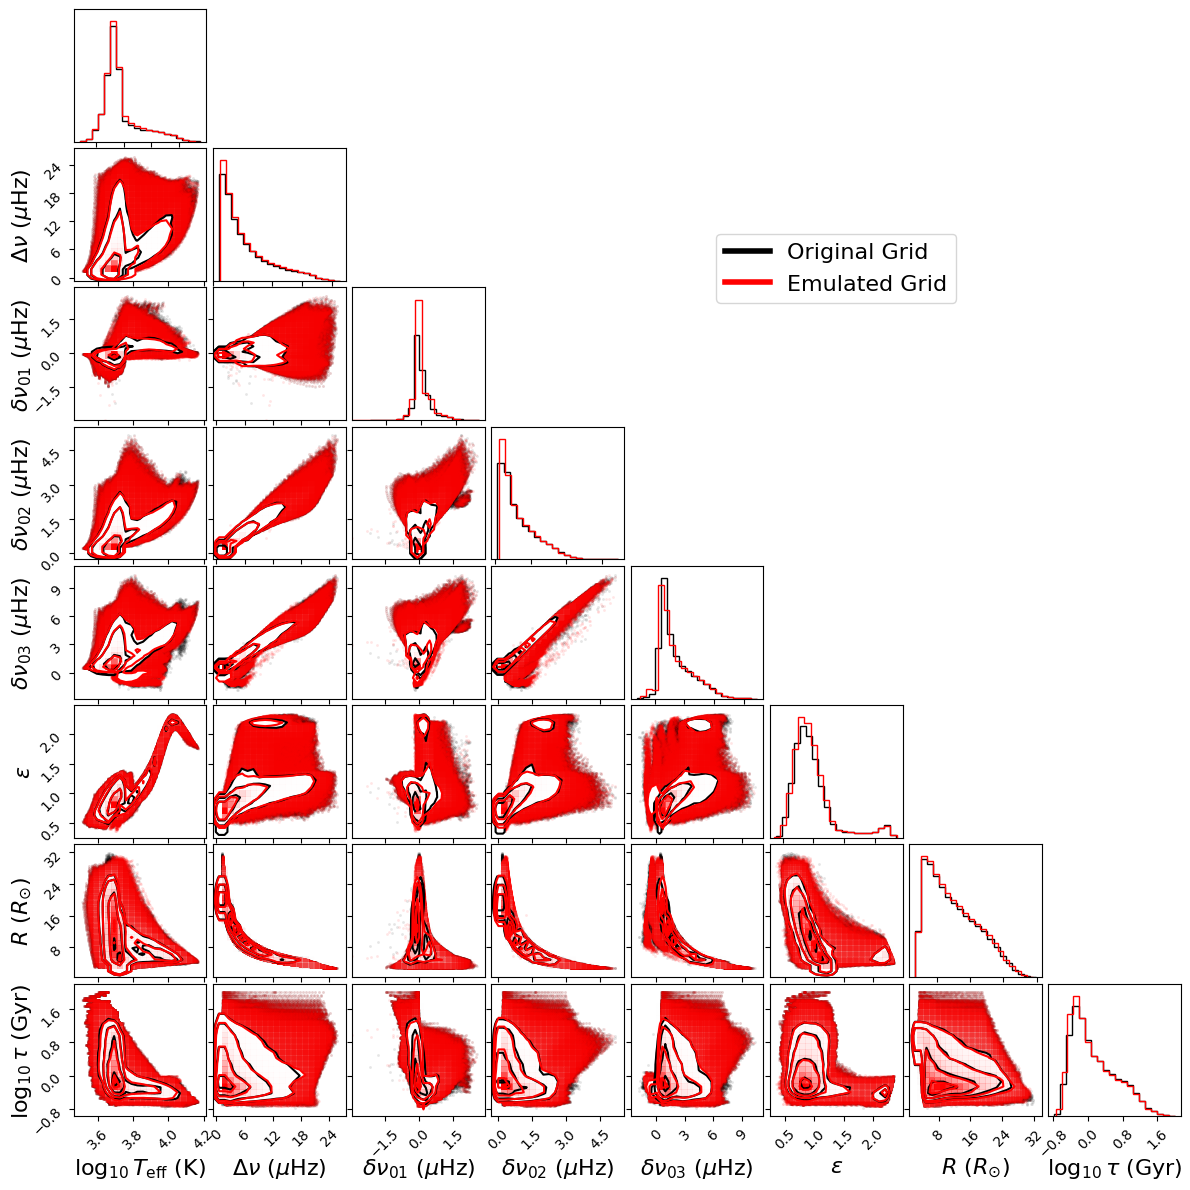

In [10]:
ndim = 8

fig = plt.figure(figsize=(12,12))
fs = 16
labels = ['$\\log_{10}T_{\\mathrm{eff}}$ (K)',
                  '$\\Delta\\nu$ ($\\mu$Hz)',
                  '$\\delta\\nu_{01}$ ($\\mu$Hz)',
                  '$\\delta\\nu_{02}$ ($\\mu$Hz)',
                  '$\\delta\\nu_{03}$ ($\\mu$Hz)',
                  '$\\epsilon$',
                  '$R$ ($R_{\\odot}$)',
                  '$\\log_{10}\\tau$ (Gyr)']


corner.corner(_pred, labels=labels,label_kwargs={"fontsize": fs}, fig=fig)
corner.corner(_output, fig=fig, color='red')

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=fs-6) 
    
legend_elements = [Line2D([0], [0], color='k', lw=4, label='Original Grid'),
                   Line2D([0], [0], color='red', lw=4, label='Emulated Grid')]


fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.8, 0.8), frameon=True, prop={'size': fs})
plt.show()

# Inference with Sampling/Importance Resampling (SIR)

### We first define a Salpeter IMF used for sampling a mass prior

In [13]:
def salpeter_imf(mass_range, alpha=2.35, size=1000):
    """
    Generate stellar masses according to the Salpeter IMF.

    Parameters:
    - mass_range: tuple or list, (min_mass, max_mass) in solar masses.
    - alpha: float, the exponent of the IMF.
    - size: int, number of stellar masses to generate.

    Returns:
    - masses: ndarray, generated stellar masses according to the Salpeter IMF.
    """
    min_mass, max_mass = mass_range
    # Convert mass limits to scale between 0 and 1 for inverse transform sampling
    min_mass_scaled = min_mass**(1.0 - alpha)
    max_mass_scaled = max_mass**(1.0 - alpha)

    # Uniform random numbers for inverse transform sampling
    random_samples = np.random.uniform(low=min_mass_scaled, high=max_mass_scaled, size=size)

    # Applying the inverse of the CDF to get masses distributed according to the Salpeter IMF
    masses = random_samples**(1.0 / (1.0 - alpha))

    return masses

### Testing the Salpeter IMF

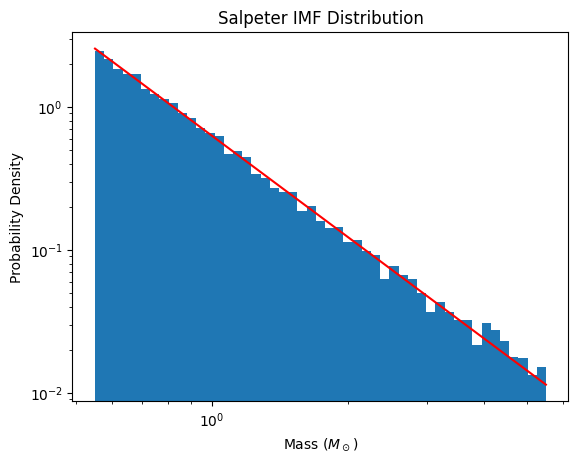

In [14]:
min_mass = 0.55  # Minimum mass in solar masses
max_mass = 5.5  # Maximum mass in solar masses
masses = salpeter_imf((min_mass, max_mass), size=10000)

mass_range = np.linspace(min_mass, max_mass, 1000)
theoretical_imf = mass_range**(-2.35)

plt.hist(masses, bins=np.logspace(np.log10(min_mass), np.log10(max_mass), 50), density=True)
plt.plot(mass_range, theoretical_imf / np.sum(theoretical_imf * np.diff(mass_range)[0]), label='Salpeter IMF', color='red')  # Normalized
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Probability Density')
plt.title('Salpeter IMF Distribution')
plt.show()

### Define helper functions for sampling and for SIR

In [22]:
def infer_samples(flow, cvar, num_samples=1):
    """
    Draws samples from the normalizing flow model.

    Args:
        flow: Normalizing flow model.
        cvar: Numpy array of size (batch x conditioning variable dims) containing the conditioning variables.
        num_samples: Number of samples per conditioning variable (default 1).

    Returns:
        ss2: Numpy array of size (batch x output dims) containing samples from the normalizing flow modelling the distribution.

    """

    with torch.no_grad():
        ss2, ss_logprobs = flow(torch.Tensor(cvar).to(device)).rsample_and_log_prob((num_samples,))
        ss_logprobs = ss_logprobs.data.cpu().numpy().squeeze()
        ss2 = (ss2.data.cpu().numpy().squeeze())

    return ss2

def calculate_luminosity_scaling_relation(teff, radius):
    """
    From a temperature and radius, determine luminosity in solar units.

    Args:
        teff: Effective temperature in Kelvin.
        radius: Radius in units of solar radii.

    Returns:
        lum: Bolometric luminosity in units of solar luminosities.

    """
    sol_teff = 5777  # Effective temperature of the Sun in Kelvin

    # Calculate the luminosity in solar units using the scaling relation
    lum = (radius ** 2) * ((teff / sol_teff) ** 4)

    return lum

def likelihood_batch(ss2, fehvar, test_dnu, test_dnu_err,
                      test_teff, test_teff_err, test_feh,
                     test_feh_err, test_d02=None, test_d02_err=None,
                    test_lum=None, test_lum_err=None):
    """
    Weight the output flow samples using a Gaussian centered about observed values
    with a FWHM of the observed values uncertainty.  Return only samples with non-zero
    weights.

    Args:
        ss2: Numpy array of size (batch x output dims) containing samples from the normalizing flow.
        fehvar: Candidate [Fe/H] values from the flow.
        test_dnu: Observed DeltaNu values.
        test_dnu_err: Observed DeltaNu uncertainties.
        test_teff: Observed effective temperature values.
        test_teff_err: Observed temperature uncertainties.
        test_feh: Observed [Fe/H] values.
        test_feh_err: Observed [Fe/H] uncertainties.
        test_d02: Observed small frequency separation values. Optional.
        test_d02_err: Observed small frequency separation uncertainties. Optional.
        test_lum: Observed bolometric luminosity values. Optional.
        test_lum_err: Observed bolometric luminosity uncertainties. Optional.

    Returns:
        likelihood: Likelihood of samples being drawn based on combined weights from observables.
        ss2: All samples with non-zero weight.

    """

    if len(ss2.shape) == 2:
        ss2 = np.expand_dims(ss2, 0)

    pred_dnu = 10**ss2[:,:,1]
    pred_radius = 10**ss2[:,:,-2]
    pred_age = 10**ss2[:,:,-1]
    pred_teff = 10**teff_scaler.inverse_transform(ss2[:,:,0]).squeeze()
    pred_d02 = 10**ss2[:,:,3]
    pred_lum = calculate_luminosity_scaling_relation(pred_teff, pred_radius).squeeze()

    draw_prob_dnu = 1/(test_dnu_err*np.sqrt(2*np.pi))  * np.exp(-0.5*np.power( pred_dnu - test_dnu, 2)/ test_dnu_err**2)
    draw_prob_teff = 1/(test_teff_err*np.sqrt(2*np.pi))  * np.exp(-0.5*np.power( pred_teff - test_teff, 2)/ test_teff_err**2)
    draw_prob_feh = 1/(test_feh_err*np.sqrt(2*np.pi))  * np.exp(-0.5*np.power( fehvar - test_feh, 2)/ test_feh_err**2)
   
    if test_d02 is not None:
        draw_prob_d02 = 1/(test_d02_err*np.sqrt(2*np.pi))  * np.exp(-0.5*np.power( pred_d02 - test_d02, 2)/ test_d02_err**2)
    else:
        draw_prob_d02 = 1.
        
    if test_lum is not None:
        draw_prob_lum = 1/(test_lum_err*np.sqrt(2*np.pi))  * np.exp(-0.5*np.power( pred_lum - test_lum, 2)/ test_lum_err**2)
    else:
        draw_prob_lum = 1.      
        
    likelihood = draw_prob_dnu  * draw_prob_teff * draw_prob_d02 * draw_prob_feh * draw_prob_lum

    return likelihood.squeeze(), ss2[likelihood != 0]

### We can define a function that runs one instance of sampling through the flow

In [23]:
def sample_batch(num_samples, clust_data, test_feh, test_feh_err, sample_idx, use_d02 = False, use_lum=False):
    """
    Draws a batch of samples from the flow and weight the samples according to the observables.
    
    Args:
        num_samples: Number of samples to draw from the normalizing flow.
        clust_data: pandas DataFrame of cluster data.
        test_feh: Observed effective temperature values. Single bulk metallicity value or an array of same length of clust_data.
        test_feh_err: Observed temperature uncertainties.
        sample_idx: Index of sample to test in clust_data.
        use_d02: If available, use observational small frequency separation data. Defaults to False.
        use_lum: If available, use observational bolometric luminosity data. Defaults to False.
    
    Returns:
        candidate_param_prob: Vector of shape (9xN) of non-zero likelihood draws of input parameters.
    """    

    num_marginals = num_samples   #  number of samples to be drawing from the flow

    ## Define initial parameters into the flow ##

    massvar = salpeter_imf((0.8, 3), size=num_marginals).T  # mass 
    fehvar = np.random.uniform(low=min(x_feh), high = max(x_feh), size=(num_marginals,)).T # logZ
    heliumvar = np.random.uniform(low=min(x_init_helium), high=max(x_init_helium), size=num_marginals) # Y
    alfvar = np.random.uniform(low=min(x_alpha), high=max(x_alpha), size=num_marginals) # alpha
    numaxvar = np.log10(np.random.normal(loc=clust_data.numax[sample_idx], 
                                scale=clust_data.e_numax[sample_idx], 
                                size=num_marginals)) # lognumax
    ovcorevar =  np.random.uniform(low=min(x_ov_core), high = max(x_ov_core), size=(num_marginals,)).T # f_ovcore
    ovenvvar =  np.random.uniform(low=min(x_ov_shell), high = max(x_ov_shell), size=(num_marginals,)).T # f_ovenv

    cv = np.ones((num_marginals, 7))
    cv[:, 0] = massvar
    cv[:, 1] = fehvar
    cv[:,2] = heliumvar
    cv[:,3] = alfvar
    cv[:,4] = ovcorevar
    cv[:,5] = ovenvvar
    cv[:,6] = numaxvar

    candidate_X = 1 - (heliumvar + 10**fehvar)
    candidate_feh = np.log10((10**fehvar)/candidate_X) - np.log10(Zsun/Xsun)

    cvar = torch.Tensor(cv).to(device) ## create PyTorch tensor
    ss2 = infer_samples(flow, cvar) ## draw samples from the flow

    ## Weight samples ##
    
    if use_d02:
        test_d02, test_d02_err = clust_data.d02[sample_idx].reshape(-1,1), clust_data.e_d02[sample_idx].reshape(-1,1)
    else:
        test_d02, test_d02_err = None, None
        
    if use_lum:
        test_lum, test_lum_err = clust_data.lum_K[sample_idx].reshape(-1,1), clust_data.e_lum_K[sample_idx].reshape(-1,1)
    else:
        test_lum, test_lum_err = None, None
        
    
    combined_likelihood,  nonzero_samples, = likelihood_batch(ss2, candidate_feh, 
                                                    clust_data.dnu[sample_idx].reshape(-1,1),
                                                    clust_data.e_dnu[sample_idx].reshape(-1,1),
                                                    clust_data.teff[sample_idx].reshape(-1,1), 
                                                    clust_data.e_teff[sample_idx].reshape(-1,1), 
                                                    test_feh, test_feh_err, test_d02, test_d02_err,
                                                             test_lum, test_lum_err)  



    ## For simplicity we can discard samples with a probability so low they are effectively zero ## 

    remaining_likelihood = combined_likelihood[combined_likelihood != 0]
    candidate_mass = massvar[combined_likelihood != 0]
    candidate_Z = fehvar[combined_likelihood != 0]
    candidate_feh = candidate_feh[combined_likelihood != 0]
    candidate_Y = heliumvar[combined_likelihood != 0]
    candidate_alf = alfvar[combined_likelihood != 0]
    candidate_coreov = ovcorevar[combined_likelihood != 0]
    candidate_shellov = ovenvvar[combined_likelihood != 0]
    candidate_age = 10**nonzero_samples[:, -1]


    ## This defines the vector of remaining samples from which we will draw using weights defined by remaining_likelihood_feh

    candidate_param = [[a, m, f, z, y, alf, coreov, shellov] for a, m, f, z, y, alf, coreov, shellov in zip(candidate_age,
                                                                               candidate_mass,
                                                                               candidate_feh,
                                                                               candidate_Z, 
                                                                               candidate_Y,
                                                                               candidate_alf,
                                                                                candidate_coreov,
                                                                                candidate_shellov)]

    candidate_param_prob = np.hstack([np.array(candidate_param), remaining_likelihood.reshape(-1,1) ])
    
    return candidate_param_prob


# We now perform inference on NGC 6791.

## Global seismic parameters are obtained from Mckeever+ (2019). Spectroscopic parameters are obtained from SDSS. In particular, temperatures are obtained from APOGEE DR16. In the event that the star does not have SDSS temperatures, we adopt the values from Basu+ (2011) instead, with an assumed uncertainty of 100K. We adopt bulk abundances of [Fe/H] = $+0.35\pm0.04$ dex from OCCAM (Donor+ 2020).

In [24]:
clust_data_ngc6791 = pd.read_csv(os.path.split(os.getcwd())[0] + '/data/inference/NGC6791.csv')
clust_data_ngc6791 = clust_data_ngc6791.merge( pd.read_csv(os.path.split(os.getcwd())[0] + '/data/inference/ngc6791_lum.csv') , on='kic')
clust_data_ngc6791

,kic,teff,e_teff,numax,e_numax,dnu,e_dnu,lum_K,e_lum_K
0,2570172,4506.108887,104.392426,74.33,0.28,7.00,0.09,23.316434,5.511432
1,2570244,4559.000000,100.000000,106.31,0.33,9.17,0.27,17.804581,4.890129
2,2438140,4543.000000,100.000000,71.37,0.24,6.72,0.10,21.218104,4.428077
3,2438333,4511.212891,99.318558,61.07,0.14,6.11,0.08,20.244332,3.678147
4,2437957,4602.000000,100.000000,92.71,0.38,8.36,0.20,18.151677,4.596311
5,2436824,4324.000000,100.000000,34.26,0.13,3.85,0.04,32.617719,5.172982
6,2435987,4428.053223,97.477470,36.26,0.20,4.19,0.04,38.404541,6.986527
7,2436209,4498.186523,103.077576,57.62,0.24,5.76,0.08,31.827138,7.097314
8,2436814,4329.883301,89.470322,25.56,0.04,3.11,0.03,47.238128,7.304594
9,2436900,4428.441895,100.874275,35.67,0.18,4.02,0.04,36.942690,6.139951


## We can draw as many samples as we like for SIR (more is better), but let's define a simple criterion where we want a minimum number of unique mass values to have been drawn from the flow.

In [25]:
### This step applies SIR. We draw 100000 samples from the flow ###

sample_idx = 1
clust_met, clust_met_err = 0.35, 0.04
use_lum = False

print('Running Inference on KIC %d' %(clust_data_ngc6791.kic[sample_idx]))

candidate_param_prob = sample_batch(100000, clust_data_ngc6791, test_feh=clust_met,
                                    test_feh_err=clust_met_err, sample_idx=sample_idx,
                                   use_lum=use_lum)

### We use the weights to define a discrete probability distribution over the candidate values ###
sir_samples = np.array(random.choices(candidate_param_prob, 
                             weights=(candidate_param_prob[:, -1]), k=100000))
unique_age, unique_indices = np.unique(sir_samples[:,0], return_index=True)
print('Unique Age Samples: %d' %len(unique_age))

### Set criterion for drawing more ####

while len(unique_age) < 5000:
    extra_param_prob = sample_batch(100000, clust_data_ngc6791, test_feh=clust_met,
                                    test_feh_err=clust_met_err, sample_idx=1,
                                   use_lum=use_lum)
    extra_samples = np.array(random.choices(extra_param_prob, 
                                 weights=(extra_param_prob[:, -1]), k=100000))
    sir_samples = np.concatenate([sir_samples, extra_samples])
    unique_age, unique_indices = np.unique(sir_samples[:,0], return_index=True)
    print('Unique Age Samples: %d' %len(unique_age))
print('Done!')

Running Inference on KIC 2570244
Unique Age Samples: 2653
Unique Age Samples: 5295
Done!


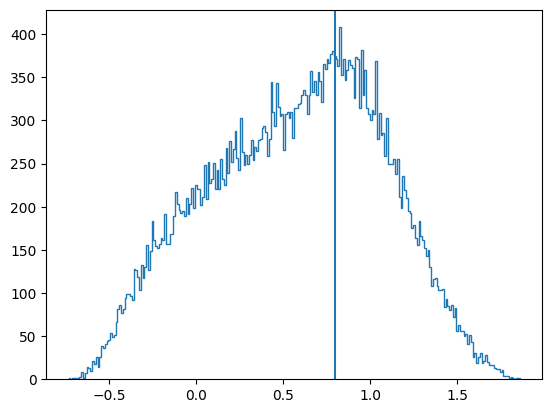

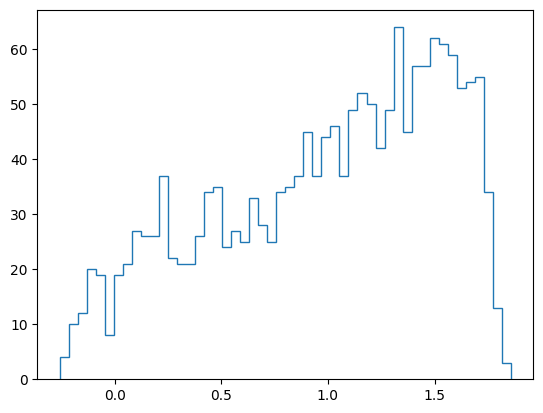

(-3.115924157475066, -1.2914659359831382)

In [44]:
plt.hist(np.log10(candidate_param_prob[:,0]), bins=250,histtype='step')
plt.axvline(x=0.8)
plt.show()
plt.hist(( np.log10(candidate_param_prob[:,0])[ (candidate_param_prob[:,3] > -1.5) & (candidate_param_prob[:,4] < 0.27)  ]), bins=50,histtype='step')
plt.show()
min(candidate_param_prob[:,3]), max(candidate_param_prob[:,3])

# The SIR samples form our posterior distribution for a given star. For the sake of visualization, let's see only samples with an age less than 15 Gyr.

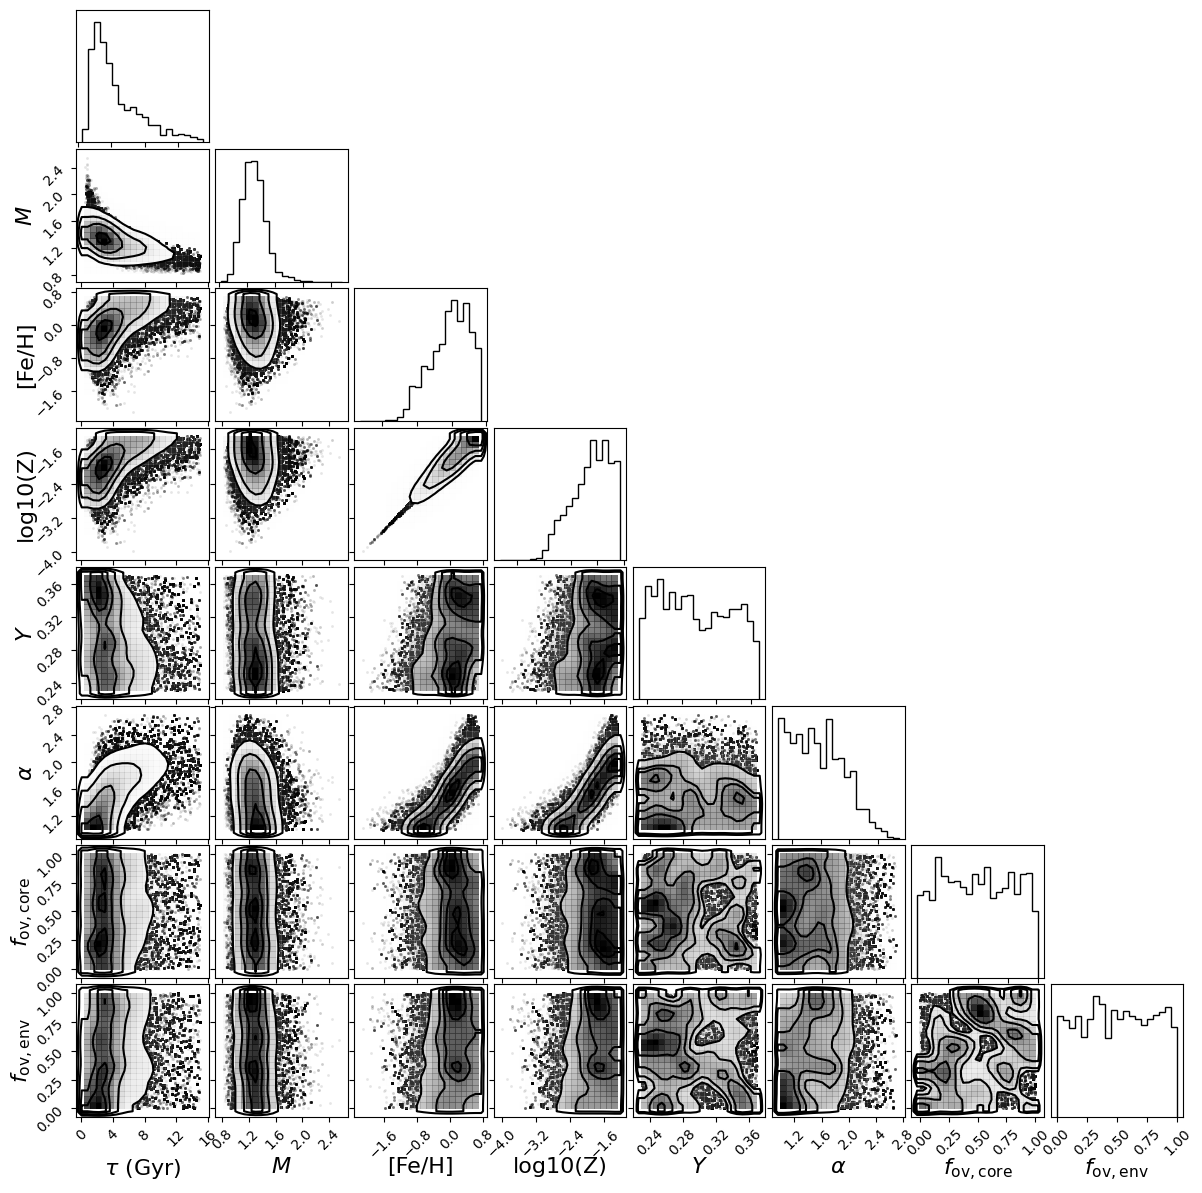

In [127]:
import corner
from matplotlib.lines import Line2D
ndim = 8

fig = plt.figure(figsize=(12,12))
fs = 16
labels = ['$\\tau$ (Gyr)', '$M$', '[Fe/H]', 'log10(Z)', '$Y$', '$\\alpha$', 
          '$f_{\\mathrm{ov, core}}$', '$f_{\\mathrm{ov, env}}$']


age_cut = sir_samples[:, 0] < 15
# age_cut_w_lum = sir_samples_w_lum[:, 0] < 15

corner.corner(sir_samples[age_cut, :-1], labels=labels,label_kwargs={"fontsize": fs}, fig=fig, smooth = 1.5,
              hist_kwargs={'density':True})
# corner.corner(sir_samples_w_lum[age_cut_w_lum, :-1], fig=fig, color='red', smooth = 1.5,
#               hist_kwargs={'density':True})


for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=fs-6) 
    
# legend_elements = [Line2D([0], [0], color='k', lw=4, label='Without Luminosity Data'),
#                    Line2D([0], [0], color='red', lw=4, label='With Luminosity Data, Uncertainties')]
# fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.8, 0.8), frameon=True, prop={'size': fs})


for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=fs-6) 
    
plt.show()

# We now perform inference on NGC 6819.

## Global seismic parameters (including $\delta\nu_{02}$) are obtained from Handberg+ (2017). Spectroscopic parameters are obtained from SDSS. In particular, temperatures are obtained from APOGEE DR16. In the event that the star does not have SDSS temperatures, we adopt the Handberg+ values and uncertainties. We adopt bulk abundances of [Fe/H] = $+0.05\pm0.03$ dex from OCCAM (Donor+ 2020).

In [128]:
clust_data_ngc6819 = pd.read_csv(os.path.split(os.getcwd())[0] + '/data/inference/NGC6819.csv')
clust_data_ngc6819 = clust_data_ngc6819.merge( pd.read_csv(os.path.split(os.getcwd())[0] + '/data/inference/ngc6819_lum.csv') , on='kic')
clust_data_ngc6819

,kic,teff,e_teff,numax,e_numax,dnu,e_dnu,d02,e_d02,lum_K,e_lum_K
0,5112734,4657.495117,79.911285,40.49,0.24,4.14,0.03,0.53,0.01,67.856257,6.009610
1,5023732,4593.374023,78.485664,27.20,0.26,3.08,0.03,0.41,0.01,89.218891,6.024776
2,5024143,4909.419922,102.704010,119.76,1.13,9.64,0.03,1.22,0.04,23.366282,1.971824
3,5024312,4816.000000,50.000000,94.80,0.63,8.01,0.03,0.98,0.02,26.976148,2.088650
4,5024297,4673.000000,50.000000,46.29,0.02,4.57,0.02,0.58,0.01,56.720226,5.609682
5,5024240,4990.696777,108.146156,150.29,2.19,11.97,0.03,1.44,0.03,18.333253,1.754679
6,5024583,4664.866211,91.609566,37.59,0.21,3.89,0.02,0.52,0.01,66.865681,4.753679
7,5111718,4927.347656,112.073921,134.26,0.62,10.50,0.03,1.29,0.02,21.481401,1.969303
8,5024405,4775.000000,50.000000,95.36,0.89,8.25,0.01,1.03,0.02,25.510638,1.997676
9,5111940,4740.225586,92.576752,53.12,0.33,5.14,0.03,0.66,0.01,48.206220,4.544781


In [69]:
### This step applies SIR. We draw 100000 samples from the flow ###

clust_met, clust_met_err = 0.05, 0.03

sample_idx = 1
use_d02=True
print('Running Inference on KIC %d' %(clust_data_ngc6819.kic[sample_idx]))

candidate_param_prob = sample_batch(100000, clust_data_ngc6819, test_feh=clust_met, 
                                    test_feh_err=clust_met_err, sample_idx=sample_idx, use_d02=use_d02)

### We use the weights to define a discrete probability distribution over the candidate values ###
sir_samples = np.array(random.choices(candidate_param_prob, 
                             weights=(candidate_param_prob[:, -1]), k=100000))
unique_age, unique_indices = np.unique(sir_samples[:,0], return_index=True)
print('Unique Age Samples: %d' %len(unique_age))

### Set criterion for drawing more ####

while len(unique_age) < 5000:

    extra_param_prob = sample_batch(100000, clust_data_ngc6819, test_feh=clust_met, 
                                    test_feh_err=clust_met_err,
                                    sample_idx=sample_idx, use_d02=use_d02)
    extra_samples = np.array(random.choices(extra_param_prob, 
                                 weights=(extra_param_prob[:, -1]), k=100000))
    sir_samples = np.concatenate([sir_samples, extra_samples])
    unique_age, unique_indices = np.unique(sir_samples[:,0], return_index=True)
    print('Unique Age Samples: %d' %len(unique_age))
print('Done!')

Running Inference on KIC 5023732
Unique Age Samples: 263
Unique Age Samples: 650
Unique Age Samples: 1074
Unique Age Samples: 1465
Unique Age Samples: 1853
Unique Age Samples: 2275
Unique Age Samples: 2674
Unique Age Samples: 3092
Unique Age Samples: 3500
Unique Age Samples: 3878
Unique Age Samples: 4255
Unique Age Samples: 4650
Unique Age Samples: 5026
Done!


#  Visualizing corner plot for a specific star for NGC 6819

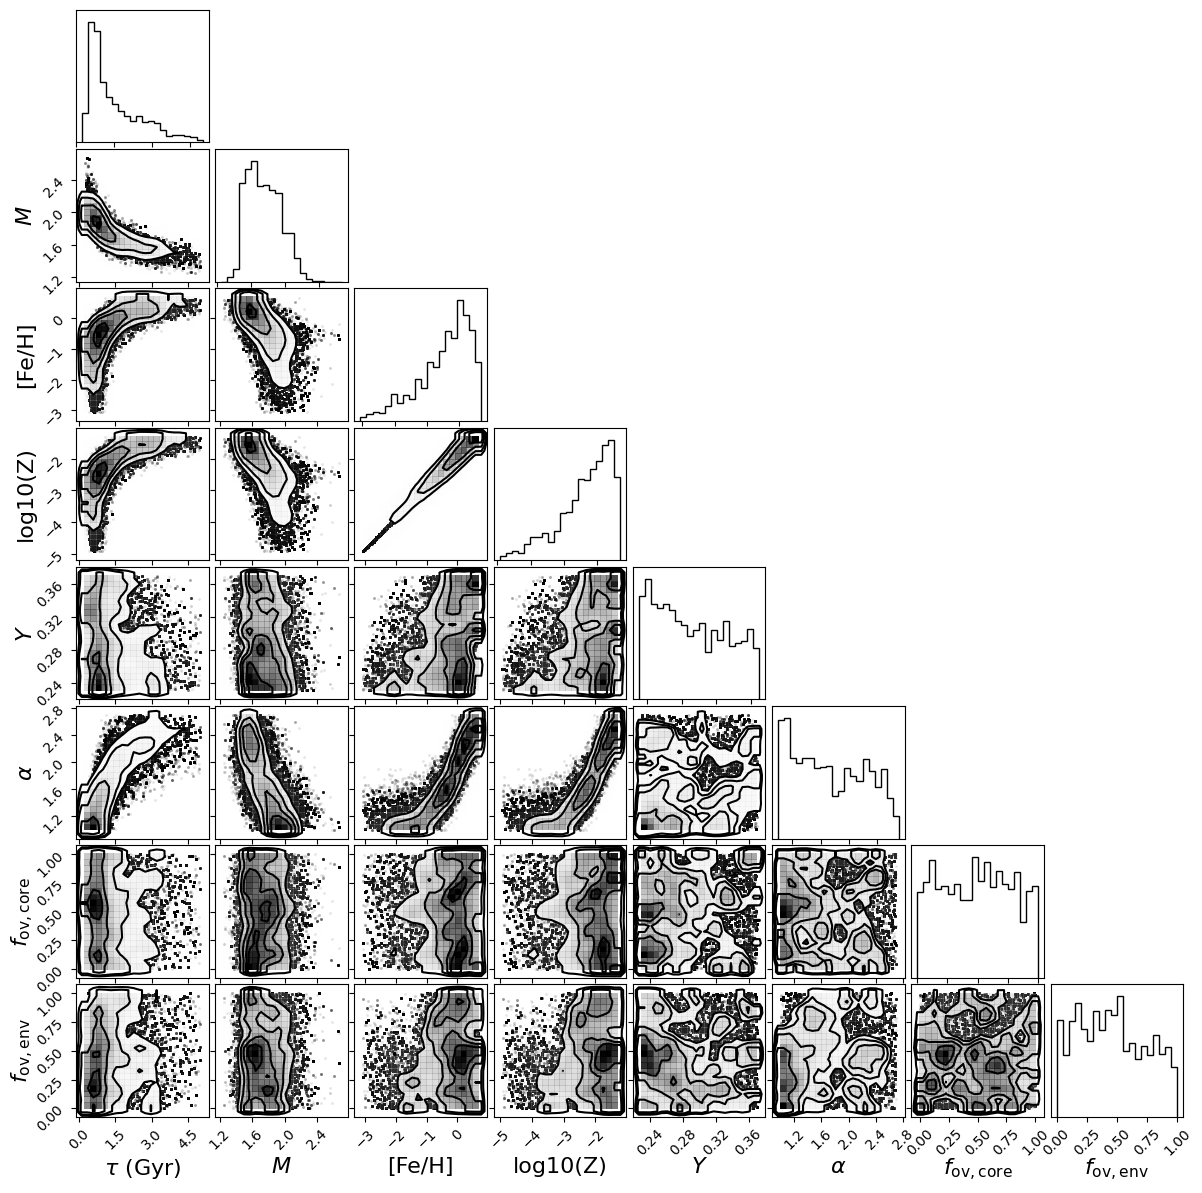

In [71]:
import corner
from matplotlib.lines import Line2D
ndim = 8

fig = plt.figure(figsize=(12,12))
fs = 16
labels = ['$\\tau$ (Gyr)', '$M$', '[Fe/H]', 'log10(Z)', '$Y$', '$\\alpha$', 
          '$f_{\\mathrm{ov, core}}$', '$f_{\\mathrm{ov, env}}$']

age_cut = sir_samples[:, 0] < 5 # for ease of visualization

corner.corner(sir_samples[age_cut, :-1], labels=labels,label_kwargs={"fontsize": fs}, fig=fig, smooth = 1)

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=fs-6) 
    
plt.show()